#breast Tumour Models

In [1]:
!wget https://www.dropbox.com/scl/fi/1d8qoh5meeyqy255xpt7p/dataset_155.zip?rlkey=jvz8dtrenifh7ylkbrmf2nky3&st=2eh55gxb&dl=0

--2024-05-30 19:09:49--  https://www.dropbox.com/scl/fi/1d8qoh5meeyqy255xpt7p/dataset_155.zip?rlkey=jvz8dtrenifh7ylkbrmf2nky3
Resolving www.dropbox.com (www.dropbox.com)... 162.125.72.18, 2620:100:6026:18::a27d:4612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.72.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc44db441d031484e6396065ef57.dl.dropboxusercontent.com/cd/0/inline/CT59Za0ImRFoaR1ZvJdSOmDhe0hvkA4Oaj0wjr6Xa_iajEtSzPN7jzSjw2xomFC3ZpUOedhoPuuf_owJdqISFhpeVduiELXB6X5RW6Aes__HgdWNUxTq-robxOIsKf32gy5Kmu7h59GMzYYzrS22d6qN/file# [following]
--2024-05-30 19:09:50--  https://uc44db441d031484e6396065ef57.dl.dropboxusercontent.com/cd/0/inline/CT59Za0ImRFoaR1ZvJdSOmDhe0hvkA4Oaj0wjr6Xa_iajEtSzPN7jzSjw2xomFC3ZpUOedhoPuuf_owJdqISFhpeVduiELXB6X5RW6Aes__HgdWNUxTq-robxOIsKf32gy5Kmu7h59GMzYYzrS22d6qN/file
Resolving uc44db441d031484e6396065ef57.dl.dropboxusercontent.com (uc44db441d031484e6396065ef57.dl.dropboxusercontent.com)... 162.125.72.15,

In [2]:

#!mv /content/dataset_155.zip?rlkey=jvz8dtrenifh7ylkbrmf2nky3 dataset_155.zip
#!unzip -qq dataset_155.zip

replace dataset_155/images/img_001.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import fnmatch
from sklearn.model_selection import train_test_split
from   skimage.color import label2rgb

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', device)

Device: cuda


In [2]:
# Definir funciones de métricas
def dice_coeff(preds, target, smooth=1e-6):
    preds = preds.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (preds * target).sum()
    return (2. * intersection + smooth) / (preds.sum() + target.sum() + smooth)

def iou(preds, target, smooth=1e-6):
    preds = preds.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (preds * target).sum()
    union = preds.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def accuracy(preds, target):
    preds = (preds > 0.5).float()
    correct = (preds == target).float().sum()
    return correct / target.numel()


In [3]:
# Función de entrenamiento por época
def train_epoch(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_dice = 0
    epoch_iou = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        img, seg = batch
        img = img.to(device)
        seg = seg.to(device)
        predictions = model(img)
        loss = criterion(predictions, seg)
        dice = dice_coeff(predictions, seg)
        iou_score = iou(predictions, seg)
        acc = accuracy(predictions, seg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_dice += dice.item()
        epoch_iou += iou_score.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_dice / len(iterator), epoch_iou / len(iterator), epoch_acc / len(iterator)

# Función de evaluación por época
def eval_epoch(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_dice = 0
    epoch_iou = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            img, seg = batch
            img = img.to(device)
            seg = seg.to(device)
            predictions = model(img)
            loss = criterion(predictions, seg)
            dice = dice_coeff(predictions, seg)
            iou_score = iou(predictions, seg)
            acc = accuracy(predictions, seg)
            epoch_loss += loss.item()
            epoch_dice += dice.item()
            epoch_iou += iou_score.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_dice / len(iterator), epoch_iou / len(iterator), epoch_acc / len(iterator)

# Función para mostrar la historia de entrenamiento
def show_history(train_loss_hist, val_loss_hist, train_dice_hist, val_dice_hist, train_iou_hist, val_iou_hist, train_acc_hist, val_acc_hist):
    epochs = range(1, len(train_loss_hist) + 1)
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss_hist, 'b', label='Training loss')
    plt.plot(epochs, val_loss_hist, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_dice_hist, 'b', label='Training Dice')
    plt.plot(epochs, val_dice_hist, 'r', label='Validation Dice')
    plt.title('Training and Validation Dice')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_iou_hist, 'b', label='Training IoU')
    plt.plot(epochs, val_iou_hist, 'r', label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_acc_hist, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc_hist, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [4]:
# Definir el conjunto de datos
class CustomDataset(Dataset):
    def __init__(self,transform=None):
        self.transform = transform
        #self.images = os.listdir(dir)

    def __len__(self):
        #return len(self.images)
        return 155


    # Functions for image reading (BY PAT01_Separation_JQ)
    def num2fixstr(self,x,d):
      # input: (21,5)
      # output: '00021'
      st = '%0*d' % (d,x)
      return st

    def imageload(self,prefix,num_img,digits_img,sep='_',echo='off'):

      st   = prefix + self.num2fixstr(num_img,digits_img) + '.tif'
      img  = Image.open(st).convert('L')

      return img

    def __getitem__(self, idx):


        image = self.imageload(f'dataset_155/images/img_',idx+1, 3)
        mask = self.imageload(f'dataset_155/masks/mask_',idx+1, 3)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [5]:
#Definir los transformadores para preprocesar las imágenes y las máscaras
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(p=0.5),
])


# Crear instancias del conjunto de datos y del cargador de datos
dataset = CustomDataset( transform=transform)

(-0.5, 127.5, 127.5, -0.5)

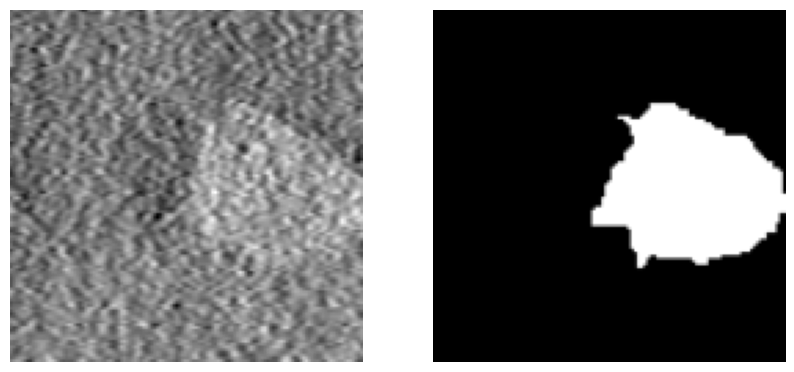

In [6]:
img, mask = dataset.__getitem__(140)
# Muestra la imagen utilizando Matplotlib

# Crea una figura con dos subtramas (una para cada imagen)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Muestra la primera imagen en la primera subtrama
axes[0].imshow(img.permute(1, 2, 0).numpy(),cmap="gray" )
axes[0].axis('off')  # Desactiva los ejes

# Muestra la segunda imagen en la segunda subtrama
axes[1].imshow(mask.permute(1, 2, 0).numpy(),cmap="gray" )
axes[1].axis('off')  # Desactiva los ejes


##Unet

In [7]:
class Unet(nn.Module):

    def __init__(self, n=64):

        super().__init__()

        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=n, out_channels=n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=2*n, out_channels=2*n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=4*n, out_channels=4*n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_4 = nn.Sequential(
            nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=8*n, out_channels=8*n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_5 = nn.Sequential(
            nn.Conv2d(in_channels=8*n, out_channels=16*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=16*n, out_channels=16*n, kernel_size=3, padding='same'),
            nn.ReLU(),
        )

        self.conv_6 = nn.Sequential(
            nn.Conv2d(in_channels=16*n, out_channels=8*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=8*n, out_channels=8*n, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.conv_7 = nn.Sequential(
            nn.Conv2d(in_channels=8*n, out_channels=4*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=4*n, out_channels=4*n, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.conv_8 = nn.Sequential(
            nn.Conv2d(in_channels=4*n, out_channels=2*n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=2*n, out_channels=2*n, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.conv_9 = nn.Sequential(
            nn.Conv2d(in_channels=2*n, out_channels=n, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=n, out_channels=n, kernel_size=3, padding='same'),
            nn.ReLU()
        )

        self.conv_A = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=1, kernel_size=1, padding='same'),
            nn.Sigmoid()
        )

        self.up_6 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=16*n, out_channels=8*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_7 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=8*n, out_channels=4*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_8 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=4*n, out_channels=2*n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

        self.up_9 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=2*n, out_channels=n, kernel_size=2, padding='same'),
            nn.ReLU()
        )

    def forward(self, input_):
        conv_1 = self.conv_1(input_)
        pool_1 = nn.MaxPool2d(kernel_size=(2,2))(conv_1)

        conv_2 = self.conv_2(pool_1)
        pool_2 = nn.MaxPool2d(kernel_size=(2,2))(conv_2)

        conv_3 = self.conv_3(pool_2)
        pool_3 = nn.MaxPool2d(kernel_size=(2,2))(conv_3)

        conv_4 = self.conv_4(pool_3)
        pool_4 = nn.MaxPool2d(kernel_size=(2,2))(conv_4)

        conv_5 = self.conv_5(pool_4)

        up_6    = self.up_6(conv_5)
        merge_6 = torch.cat([conv_4, up_6], dim=1)
        conv_6  = self.conv_6(merge_6)

        up_7    = self.up_7(conv_6)
        merge_7 = torch.cat([conv_3, up_7], dim=1)
        conv_7  = self.conv_7(merge_7)

        up_8    = self.up_8(conv_7)
        merge_8 = torch.cat([conv_2, up_8], dim=1)
        conv_8  = self.conv_8(merge_8)

        up_9    = self.up_9(conv_8)
        merge_9 = torch.cat([conv_1, up_9], dim=1)
        conv_9  = self.conv_9(merge_9)

        return self.conv_A(conv_9)

In [8]:

# Crear el conjunto de datos
dataset = CustomDataset(transform=transform)

# Dividir el conjunto de datos en conjuntos de entrenamiento y validación
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_indices, test_indices = train_test_split(train_indices, test_size=0.2, random_state=42)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Crear cargadores de datos para el conjunto de entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)


In [9]:
# Definir la función de pérdida
criterion = nn.BCELoss().to(device)

# Instanciar el modelo U-Net
model = Unet().to(device)

# Definir el optimizador
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay = 1e-5)


/home4/cxalfaro/miniconda3/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,


1/80 ---- Training Loss: 0.7271 ---- Training Dice: 0.1531 ---- Training IoU: 0.0835 ---- Training Accuracy: 0.0860 ---- Validation Loss: 0.7121 ---- Validation Dice: 0.1510 ---- Validation IoU: 0.0821 ---- Validation Accuracy: 0.0843
2/80 ---- Training Loss: 0.6785 ---- Training Dice: 0.1510 ---- Training IoU: 0.0821 ---- Training Accuracy: 0.5538 ---- Validation Loss: 0.5703 ---- Validation Dice: 0.1368 ---- Validation IoU: 0.0737 ---- Validation Accuracy: 0.9031
3/80 ---- Training Loss: 0.4846 ---- Training Dice: 0.0856 ---- Training IoU: 0.0456 ---- Training Accuracy: 0.9031 ---- Validation Loss: 0.4483 ---- Validation Dice: 0.1160 ---- Validation IoU: 0.0618 ---- Validation Accuracy: 0.9035
4/80 ---- Training Loss: 0.4013 ---- Training Dice: 0.0715 ---- Training IoU: 0.0372 ---- Training Accuracy: 0.9021 ---- Validation Loss: 0.3550 ---- Validation Dice: 0.0780 ---- Validation IoU: 0.0406 ---- Validation Accuracy: 0.9035
5/80 ---- Training Loss: 0.3566 ---- Training Dice: 0.0845 -

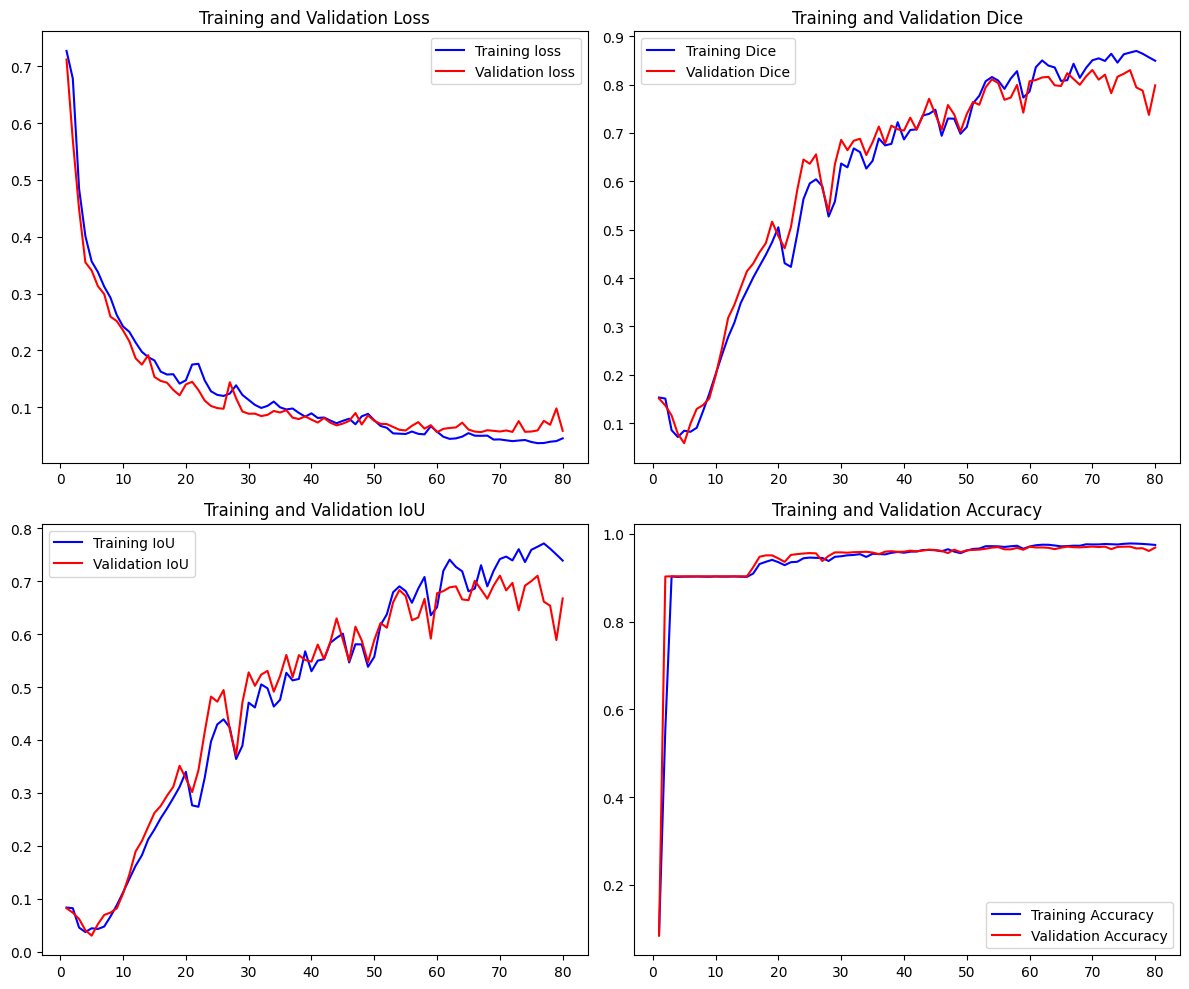

In [10]:
# Variables de configuración
num_epochs = 80
train_loss_hist = []
val_loss_hist = []
train_dice_hist = []
val_dice_hist = []
train_iou_hist = []
val_iou_hist = []
train_acc_hist = []
val_acc_hist = []

# Bucle de entrenamiento y evaluación
for epoch in range(num_epochs):
    train_loss, train_dice, train_iou, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice, val_iou, val_acc = eval_epoch(model, val_loader, criterion, device)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_dice_hist.append(train_dice)
    val_dice_hist.append(val_dice)
    train_iou_hist.append(train_iou)
    val_iou_hist.append(val_iou)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(f'{epoch + 1}/{num_epochs} ---- Training Loss: {train_loss:.4f} ---- Training Dice: {train_dice:.4f} ---- Training IoU: {train_iou:.4f} ---- Training Accuracy: {train_acc:.4f} ---- Validation Loss: {val_loss:.4f} ---- Validation Dice: {val_dice:.4f} ---- Validation IoU: {val_iou:.4f} ---- Validation Accuracy: {val_acc:.4f}')

# Mostrar la historia de pérdidas y métricas al final del entrenamiento
show_history(train_loss_hist, val_loss_hist, train_dice_hist, val_dice_hist, train_iou_hist, val_iou_hist, train_acc_hist, val_acc_hist)


Test Loss: 0.0967 ---- Test Dice: 0.8259 ---- Test IoU: 0.7055 ---- Test Accuracy: 0.9576


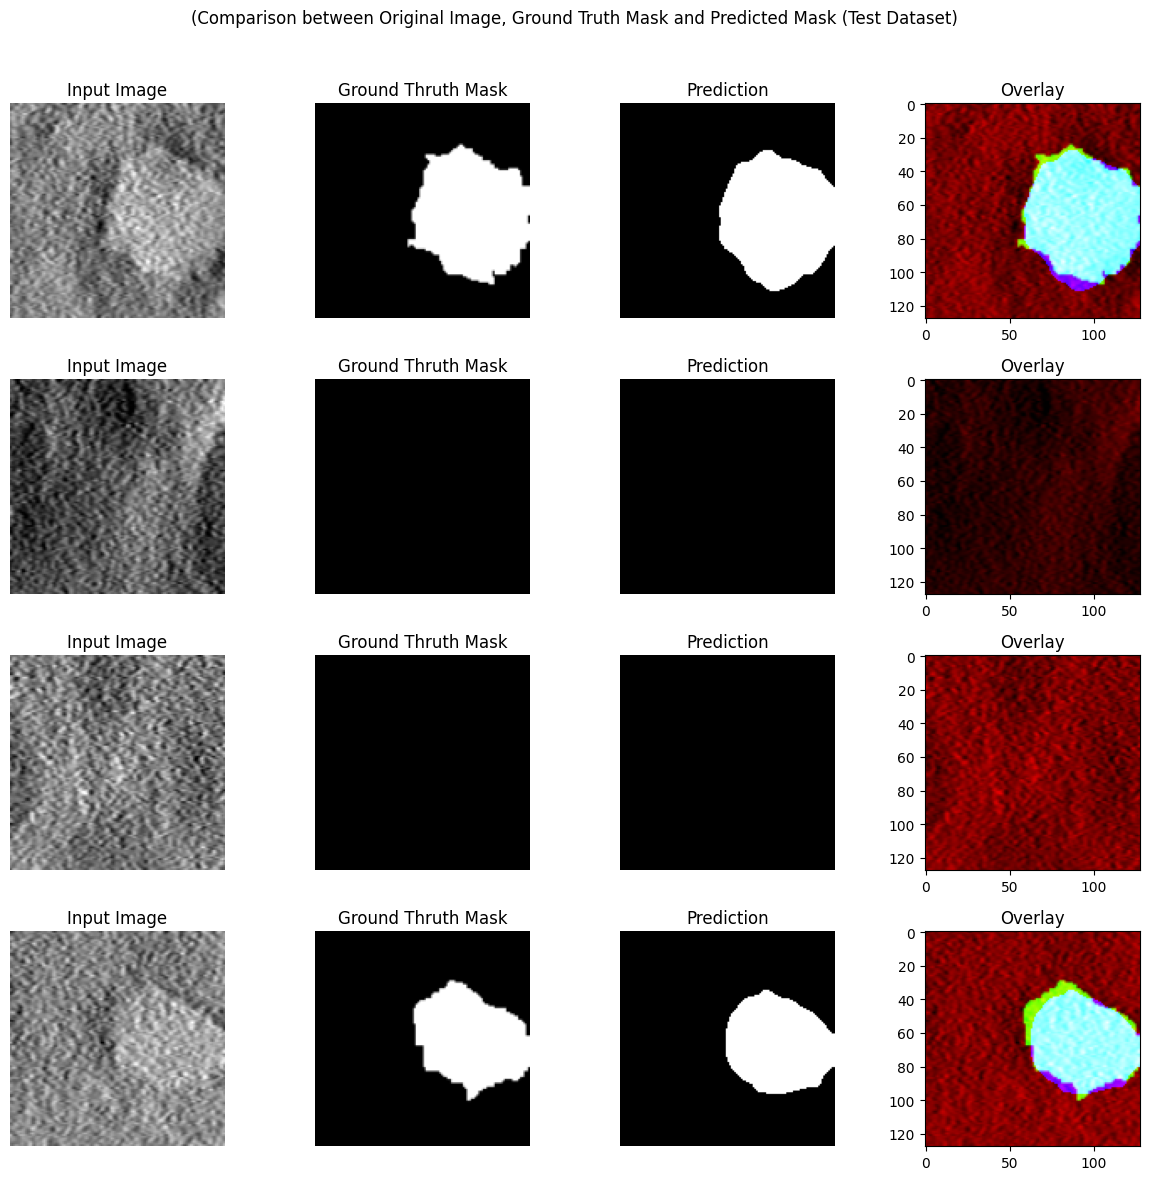

In [11]:
# Evaluar en el conjunto de prueba
model.eval()
with torch.no_grad():
    test_loss, test_dice, test_iou, test_acc = eval_epoch(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f} ---- Test Dice: {test_dice:.4f} ---- Test IoU: {test_iou:.4f} ---- Test Accuracy: {test_acc:.4f}')

# Mostrar algunas predicciones del conjunto de prueba
test_batch = next(iter(test_loader))
test_img, test_seg = test_batch
test_img = test_img.to(device)
test_seg = test_seg.to(device)
predictions = model(test_img)
preds = (predictions > 0.5).float()

# Crear una figura con tres subtramas (una para cada imagen)
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('(Comparison between Original Image, Ground Truth Mask and Predicted Mask (Test Dataset)')

for i in range(4):
    # Mostrar imagen original
    axes[i][0].imshow(test_img[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')
    axes[i][0].set_title('Input Image')
    axes[i][0].axis('off')

    # Mostrar máscara real
    axes[i][1].imshow(test_seg[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')
    axes[i][1].set_title('Ground Thruth Mask')
    axes[i][1].axis('off')

    # Mostrar máscara predicha
    axes[i][2].imshow(preds[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')
    axes[i][2].set_title('Prediction')
    axes[i][2].axis('off')
    
    
     #Overlay of the results
    
    overlay = np.zeros((test_img[i].cpu().numpy().squeeze().shape[0], test_img[i].cpu().numpy().squeeze().shape[1], 3))
    overlay[:, :, 0] = test_img[i].cpu().numpy().squeeze()
    overlay[:, :, 1] = test_seg[i].cpu().numpy().squeeze()
    overlay[:, :, 2] = preds[i].cpu().numpy().squeeze()
    axes[i][3].imshow(overlay,cmap ='copper')
    
    axes[i][3].set_title('Overlay')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




## FCN FULLY CONVOLUTIONAL NN (pretrained)

In [28]:
import torchvision
from torchvision.models.segmentation import fcn_resnet50

# Cargar un modelo FCN preentrenado en COCO
model = fcn_resnet50(pretrained=True)

# Modificar la primera capa para aceptar imágenes de un canal
model.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(3, 3) , stride=(1, 1), padding = (1, 1), bias= False)

# Modificar la última capa para tener dos clases (fondo y objeto)
model.classifier[4] = torch.nn.Conv2d(512, 2, kernel_size=(3, 3), stride=(1,1))

model = model.to(device)

In [29]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for imgs, masks in data_loader:
        imgs = imgs.to(device)
        masks = masks.to(device).long().squeeze(1)  # Ajustar las dimensiones de las máscaras

        optimizer.zero_grad()
        outputs = model(imgs)['out']

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

def eval_epoch(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for imgs, masks in data_loader:
            imgs = imgs.to(device)
            masks = masks.to(device).long().squeeze(1)  # Ajustar las dimensiones de las máscaras

            outputs = model(imgs)['out']
            loss = criterion(outputs, masks)

            epoch_loss += loss.item()

    return epoch_loss / len(data_loader)


In [30]:
num_epochs = 30

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = eval_epoch(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/30, Train Loss: 0.3853, Val Loss: 0.8712
Epoch 2/30, Train Loss: 0.1295, Val Loss: 0.5941
Epoch 3/30, Train Loss: 0.0863, Val Loss: 0.7300
Epoch 4/30, Train Loss: 0.0679, Val Loss: 0.6116
Epoch 5/30, Train Loss: 0.0612, Val Loss: 0.2319
Epoch 6/30, Train Loss: 0.0501, Val Loss: 0.2856
Epoch 7/30, Train Loss: 0.0451, Val Loss: 0.2440
Epoch 8/30, Train Loss: 0.0435, Val Loss: 0.1342
Epoch 9/30, Train Loss: 0.0422, Val Loss: 0.1021
Epoch 10/30, Train Loss: 0.0321, Val Loss: 0.0880
Epoch 11/30, Train Loss: 0.0370, Val Loss: 0.0894
Epoch 12/30, Train Loss: 0.0316, Val Loss: 0.0971
Epoch 13/30, Train Loss: 0.0307, Val Loss: 0.1153
Epoch 14/30, Train Loss: 0.0272, Val Loss: 0.0986
Epoch 15/30, Train Loss: 0.0233, Val Loss: 0.0996
Epoch 16/30, Train Loss: 0.0251, Val Loss: 0.1175
Epoch 17/30, Train Loss: 0.0218, Val Loss: 0.1147
Epoch 18/30, Train Loss: 0.0207, Val Loss: 0.1290
Epoch 19/30, Train Loss: 0.0189, Val Loss: 0.1247
Epoch 20/30, Train Loss: 0.0186, Val Loss: 0.1178
Epoch 21/

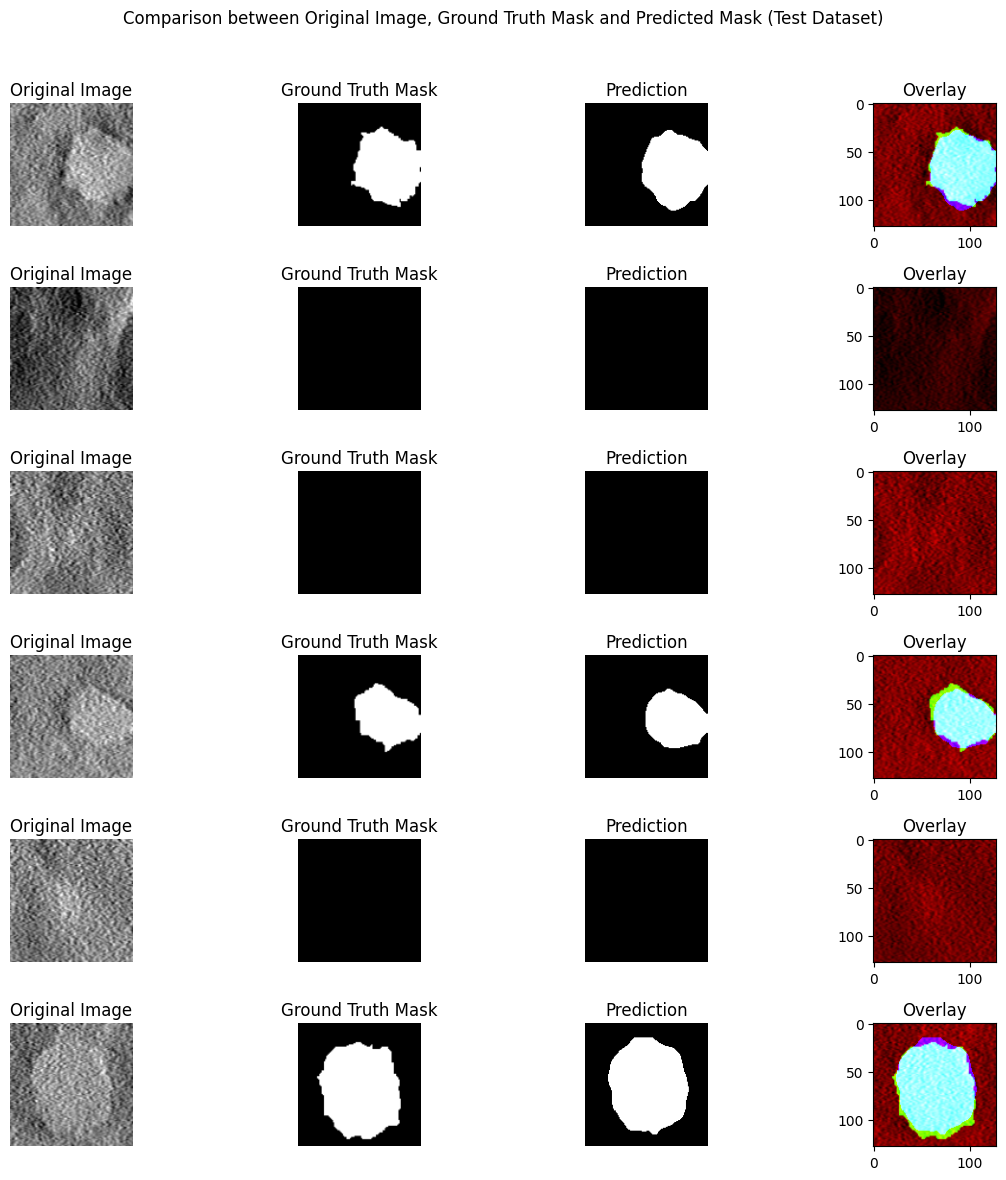

In [21]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    test_batch = next(iter(test_loader))
    test_imgs, test_masks = test_batch
    test_imgs = test_imgs.to(device)
    outputs = model(test_imgs)['out']
    preds = torch.argmax(outputs)
    preds = (predictions > 0.5).float()

# Crear una figura con tres subtramas (una para cada imagen)
fig, axes = plt.subplots(6, 4, figsize=(12, 12))
fig.suptitle('Comparison between Original Image, Ground Truth Mask and Predicted Mask (Test Dataset)')

for i in range(6):
    # Mostrar imagen original
    axes[i][0].imshow(test_imgs[i].permute(1, 2, 0).cpu().numpy(), cmap = 'gray')
    axes[i][0].set_title('Original Image')
    axes[i][0].axis('off')

    # Mostrar máscara real
    #mask = test_masks[i].permute(1, 2, 0).cpu().numpy(), cmap= 'gray')  # Ajustar las dimensiones de la máscara real
    axes[i][1].imshow(test_masks[i].permute(1, 2, 0).cpu().numpy(),cmap = 'gray')
    axes[i][1].set_title('Ground Truth Mask')
    axes[i][1].axis('off')

    # Mostrar máscara predicha
    #pred_mask = preds[i].permute(1, 2, 0).cpu().numpy(),cmap= 'gray')  # La máscara predicha ya tiene la forma correcta
    axes[i][2].imshow(preds[i].permute(1, 2, 0).cpu().numpy(),cmap = 'gray')
    axes[i][2].set_title('Prediction')
    axes[i][2].axis('off')
    
     #Overlay of the results
    
    overlay = np.zeros((test_imgs[i].cpu().numpy().squeeze().shape[0], test_imgs[i].cpu().numpy().squeeze().shape[1], 3))
    overlay[:, :, 0] = test_imgs[i].cpu().numpy().squeeze()
    overlay[:, :, 1] = test_masks[i].cpu().numpy().squeeze()
    overlay[:, :, 2] = preds[i].cpu().numpy().squeeze()
    axes[i][3].imshow(overlay,cmap ='copper')
    
    axes[i][3].set_title('Overlay')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
